In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100

In [3]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape(img_shape))
    return model

In [4]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [5]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [6]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

In [7]:
generator = build_generator(img_shape, z_dim)
discriminator.trainable = False
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [8]:
z = np.random.normal(0,1, (1, 100))

In [9]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

In [10]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    (x_train, _), (_ , _) = mnist.load_data()
    x_train = x_train / 127.5 - 1.0
    x_train = np.expand_dims(x_train, axis=3)
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]
        z = np.random.normal(0,1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        d_loss_real = discriminator.train_on_batch(imgs,real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0,1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        g_loss = gan.train_on_batch(z, real)
        
        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            sample_images(generator)

/Users/amanjeet/anaconda3/envs/deeplearning/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/amanjeet/anaconda3/envs/deeplearning/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.064623, acc.: 98.83%] [G loss: 3.598225]
2000 [D loss: 0.055728, acc.: 97.66%] [G loss: 6.090003]
3000 [D loss: 0.245123, acc.: 91.02%] [G loss: 3.315397]
4000 [D loss: 0.421501, acc.: 82.03%] [G loss: 3.716576]
5000 [D loss: 0.332072, acc.: 86.72%] [G loss: 4.184670]
6000 [D loss: 0.157077, acc.: 94.14%] [G loss: 4.020056]
7000 [D loss: 0.195875, acc.: 94.14%] [G loss: 4.792993]
8000 [D loss: 0.177865, acc.: 93.75%] [G loss: 5.286363]
9000 [D loss: 0.243409, acc.: 89.45%] [G loss: 4.307683]
10000 [D loss: 0.425608, acc.: 82.42%] [G loss: 4.115122]
11000 [D loss: 0.386671, acc.: 83.59%] [G loss: 3.490379]
12000 [D loss: 0.251554, acc.: 87.50%] [G loss: 3.325888]
13000 [D loss: 0.222940, acc.: 89.84%] [G loss: 4.307262]
14000 [D loss: 0.246208, acc.: 91.80%] [G loss: 3.688506]
15000 [D loss: 0.379204, acc.: 83.59%] [G loss: 3.152722]
16000 [D loss: 0.362258, acc.: 85.16%] [G loss: 3.453741]
17000 [D loss: 0.537343, acc.: 77.34%] [G loss: 2.663789]
18000 [D loss: 0.248199

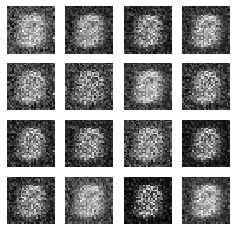

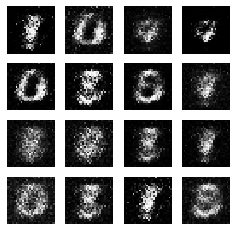

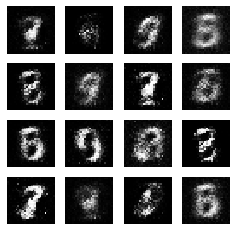

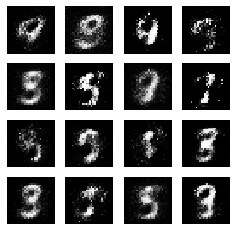

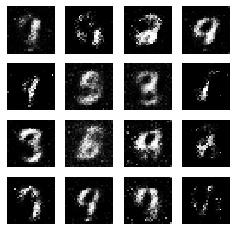

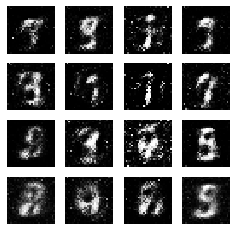

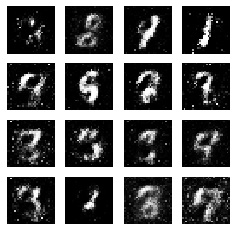

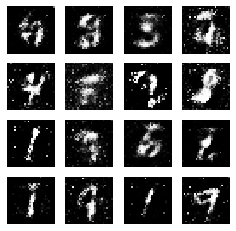

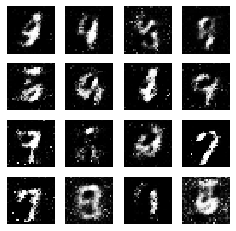

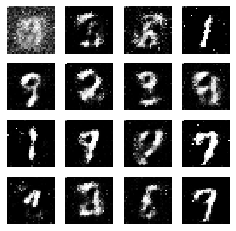

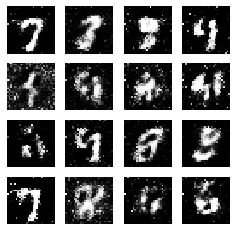

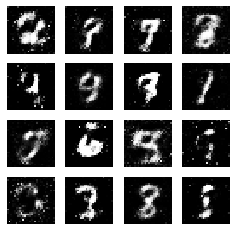

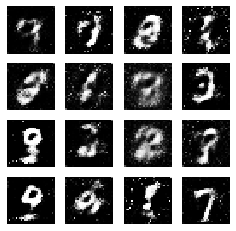

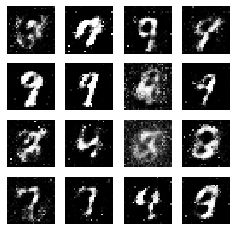

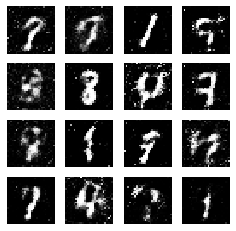

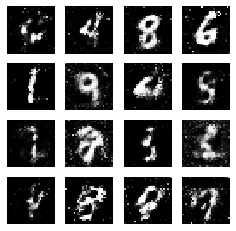

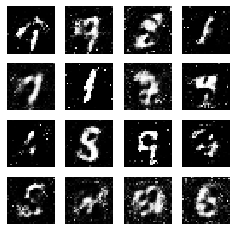

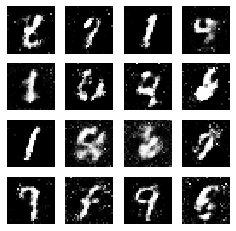

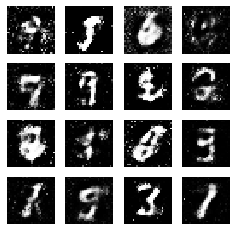

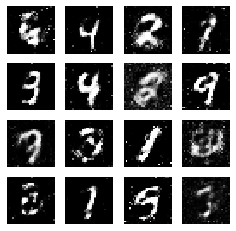

In [11]:
iterations = 20000
batch_size = 128
sample_interval = 1000
train(iterations, batch_size, sample_interval)

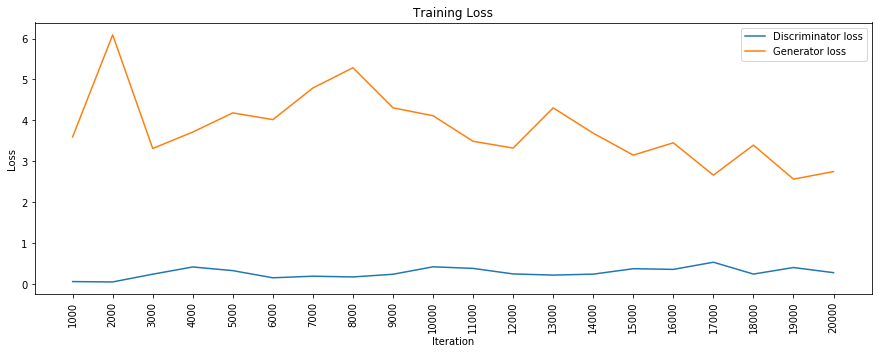

In [12]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

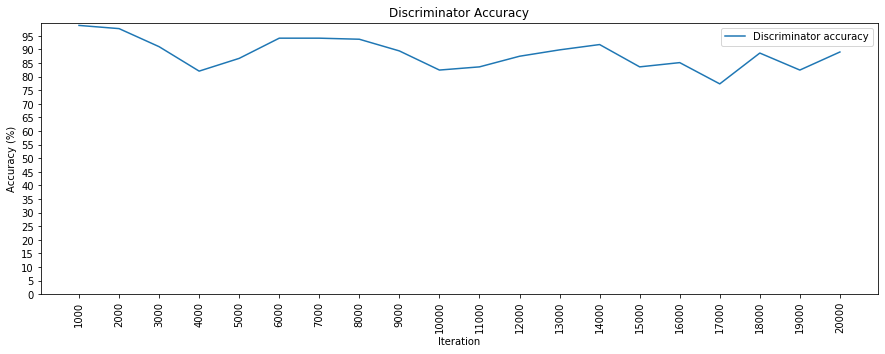

In [13]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()